## For trying out new backend code

In [18]:
from pydantic import BaseModel
from typing import List, Optional, Tuple
from datetime import datetime

class BasicInfo(BaseModel):
    currentAge: int
    retirementAge: int
    currentSavings: float
    retirementSpendingRaw: float

class ScenarioValues(BaseModel):
    min: float
    avg: float
    max: float

class GrowthScenarios(BaseModel):
    inflation: ScenarioValues
    growth: ScenarioValues

class GrowthAssumptions(BaseModel):
    annualInflation: float
    inflationErrorMargin: float
    investmentReturnRate: float
    investmentReturnErrorMargin: float

    def to_scenarios(self):
        return GrowthScenarios(
            inflation=ScenarioValues(
                min=self.annualInflation - self.inflationErrorMargin,
                avg=self.annualInflation,
                max=self.annualInflation + self.inflationErrorMargin,
            ),
            growth=ScenarioValues(
                min=self.investmentReturnRate - self.investmentReturnErrorMargin,
                avg=self.investmentReturnRate,
                max=self.investmentReturnRate + self.investmentReturnErrorMargin,
            ),
        )


In [19]:
assumptions = GrowthAssumptions(
    annualInflation=0.03,
    inflationErrorMargin=0.02,
    investmentReturnRate=0.06,
    investmentReturnErrorMargin=0.01
)
scenarios = assumptions.to_scenarios()
print(scenarios.growth.min)

0.049999999999999996


In [22]:
class ContributionBreakpoint(BaseModel):
    '''starting at fromAge, contribution = base * (1 + changeYoY)^(years since fromAge).
       If years is None, it runs until the next breakpoint (or retirement).'''
    fromAge: int
    base: float
    changeYoY: float
    years: Optional[int] = None

class SavingsPlan(BaseModel):
    breakpoints: List[ContributionBreakpoint] = []

class YearRow(BaseModel):
    age: int
    year: int
    contribution: float
    growth: ScenarioValues
    savings: ScenarioValues

#helper functions here
def _make_intervals(
    rows: List[ContributionBreakpoint],
    stop_age: int
) -> List[Tuple[int, int, ContributionBreakpoint]]:
    """Return [(startAge, endAgeExclusive, row), ...], sorted by start."""
    rows_sorted = sorted(rows, key=lambda r: r.fromAge)
    out: List[Tuple[int, int, ContributionBreakpoint]] = []
    for i, row in enumerate(rows_sorted):
        next_start = rows_sorted[i + 1].fromAge if i + 1 < len(rows_sorted) else stop_age
        # if years is None, run until the next breakpoint; else for `years` years
        end = row.fromAge + (row.years if row.years is not None else max(next_start - row.fromAge, 0))
        if end <= row.fromAge:      # guard against weird inputs
            end = next_start
        out.append((row.fromAge, end, row))
    return out

def _active_row(
    intervals: List[Tuple[int, int, ContributionBreakpoint]],
    age: int
) -> Optional[ContributionBreakpoint]:
    for start, end, row in intervals:
        if start <= age < end:
            return row
    return None

#main projection mechanism
def project_savings_table(
    basic: BasicInfo,
    assumptions: GrowthAssumptions,
    plan: SavingsPlan,
    current_year: Optional[int] = None,
) -> List[YearRow]:
    """
    Build a year-by-year table from currentAge..retirementAge (inclusive).

    Order of operations (per year):
      1) Add contribution at START of year (uses active breakpoint).
      2) Apply GROWTH for the year (min/avg/max nominal rates, annual compounding).
      3) Record row with nested {growth: {min,avg,max}, savings: {min,avg,max}}.

    Starts from basic.currentSavings BEFORE the first year's contribution.
    """
    scenarios = assumptions.to_scenarios()  # has scenarios.growth.min/avg/max

    # if no breakpoints are provided, default to "no contributions"
    default_years = max(0, basic.retirementAge - basic.currentAge)
    intervals = _make_intervals(
        plan.breakpoints or [ContributionBreakpoint(fromAge=basic.currentAge, base=0.0, changeYoY=0.0, years=default_years)],
        stop_age=basic.retirementAge + 1,
    )

    year0 = current_year or datetime.now().year

    bal_min = float(basic.currentSavings)
    bal_avg = float(basic.currentSavings)
    bal_max = float(basic.currentSavings)

    rows: List[YearRow] = []
    for step, age in enumerate(range(basic.currentAge, basic.retirementAge + 1)):
        year = year0 + step

        # compute contribution for this age
        contrib = 0.0
        rule = _active_row(intervals, age)
        if rule:
            t = age - rule.fromAge  # years since this breakpoint began
            contrib = rule.base * ((1.0 + rule.changeYoY) ** t)

        # 1) apply growth for the full year
        gmin, gavg, gmax = scenarios.growth.min, scenarios.growth.avg, scenarios.growth.max
        bal_min *= (1.0 + gmin)
        bal_avg *= (1.0 + gavg)
        bal_max *= (1.0 + gmax)

        # 2) add contribution at end of year
        bal_min += contrib
        bal_avg += contrib
        bal_max += contrib

        # 3) record row (rounded a bit for nice output)
        rows.append(YearRow(
            age=age,
            year=year,
            contribution=round(contrib, 2),
            growth=ScenarioValues(min=gmin, avg=gavg, max=gmax),
            savings=ScenarioValues(
                min=round(bal_min, 2),
                avg=round(bal_avg, 2),
                max=round(bal_max, 2),
            ),
        ))

    return rows



In [23]:
    basic = BasicInfo(currentAge=22, retirementAge=59, currentSavings=0.0, retirementSpendingRaw=40000.0)
    assumptions = GrowthAssumptions(
        annualInflation=0.03, inflationErrorMargin=0.00,   # inflation not used in this projection yet
        investmentReturnRate=0.06, investmentReturnErrorMargin=0.01
    )
    plan = SavingsPlan(breakpoints=[
        ContributionBreakpoint(fromAge=22, base=1000.0, changeYoY=0.03)  # runs until retirement
    ])
    table = project_savings_table(basic, assumptions, plan)
    for r in table:
        print(f"age {r.age} | year {r.year} | contrib {r.contribution:.2f} | "
              f"savings.min {r.savings.min:.2f} | savings.avg {r.savings.avg:.2f} | savings.max {r.savings.max:.2f}")

age 22 | year 2025 | contrib 1000.00 | savings.min 1000.00 | savings.avg 1000.00 | savings.max 1000.00
age 23 | year 2026 | contrib 1030.00 | savings.min 2080.00 | savings.avg 2090.00 | savings.max 2100.00
age 24 | year 2027 | contrib 1060.90 | savings.min 3244.90 | savings.avg 3276.30 | savings.max 3307.90
age 25 | year 2028 | contrib 1092.73 | savings.min 4499.87 | savings.avg 4565.61 | savings.max 4632.18
age 26 | year 2029 | contrib 1125.51 | savings.min 5850.37 | savings.avg 5965.05 | savings.max 6081.94
age 27 | year 2030 | contrib 1159.27 | savings.min 7302.17 | savings.avg 7482.23 | savings.max 7666.95
age 28 | year 2031 | contrib 1194.05 | savings.min 8861.33 | savings.avg 9125.21 | savings.max 9397.69
age 29 | year 2032 | contrib 1229.87 | savings.min 10534.27 | savings.avg 10902.60 | savings.max 11285.40
age 30 | year 2033 | contrib 1266.77 | savings.min 12327.75 | savings.avg 12823.53 | savings.max 13342.15
age 31 | year 2034 | contrib 1304.77 | savings.min 14248.91 | savin

## Trial

In [ ]:
from pydantic import BaseModel
from typing import List, Optional, Tuple
from datetime import datetime

# -------------------
# Core data models
# -------------------

class BasicInfo(BaseModel):
    currentAge: int
    retirementAge: int
    currentSavings: float
    # User's desired annual spending in today's dollars (e.g. 40000)
    retirementSpendingRaw: float
    # How far to project (optional). If None, we'll go 30 years past retirement.
    finalAge: Optional[int] = None


class ScenarioValues(BaseModel):
    min: float
    avg: float
    max: float


class GrowthScenarios(BaseModel):
    inflation: ScenarioValues    # per-scenario inflation
    growth: ScenarioValues       # per-scenario nominal investment returns


class GrowthAssumptions(BaseModel):
    annualInflation: float
    inflationErrorMargin: float
    investmentReturnRate: float
    investmentReturnErrorMargin: float

    def to_scenarios(self) -> GrowthScenarios:
        return GrowthScenarios(
            inflation=ScenarioValues(
                min=self.annualInflation - self.inflationErrorMargin,
                avg=self.annualInflation,
                max=self.annualInflation + self.inflationErrorMargin,
            ),
            growth=ScenarioValues(
                min=self.investmentReturnRate - self.investmentReturnErrorMargin,
                avg=self.investmentReturnRate,
                max=self.investmentReturnRate + self.investmentReturnErrorMargin,
            ),
        )


class ContributionBreakpoint(BaseModel):
    """
    Starting at fromAge, contribution for that year is:
      base * (1 + changeYoY)^(years since fromAge).

    If years is None, it runs until the next breakpoint (or retirement).
    Contributions only apply while age < retirementAge.
    """
    fromAge: int
    base: float
    changeYoY: float = 0.0   # default: flat contribution in nominal dollars
    years: Optional[int] = None


class SavingsPlan(BaseModel):
    breakpoints: List[ContributionBreakpoint] = []


class YearRow(BaseModel):
    age: int
    year: int
    contribution: float            # this year's contribution (if any)
    growth: ScenarioValues         # growth rates used (min/avg/max)
    spending: ScenarioValues       # retirement spending actually deducted (nominal)
    savings: ScenarioValues        # balances AFTER spending + growth (+ contrib if working year)


# -------------------
# Helpers
# -------------------

def _make_intervals(
    rows: List[ContributionBreakpoint],
    stop_age: int
) -> List[Tuple[int, int, ContributionBreakpoint]]:
    """
    Turn breakpoint rows into intervals:
      [(startAge, endAgeExclusive, row), ...], sorted by start.
    """
    rows_sorted = sorted(rows, key=lambda r: r.fromAge)
    out: List[Tuple[int, int, ContributionBreakpoint]] = []

    for i, row in enumerate(rows_sorted):
        next_start = rows_sorted[i + 1].fromAge if i + 1 < len(rows_sorted) else stop_age
        # if years is None, run until the next breakpoint; else for `years` years
        span = row.years if row.years is not None else max(next_start - row.fromAge, 0)
        end = row.fromAge + span
        if end <= row.fromAge:
            end = next_start  # basic guard against bad input
        out.append((row.fromAge, end, row))

    return out


def _active_row(
    intervals: List[Tuple[int, int, ContributionBreakpoint]],
    age: int
) -> Optional[ContributionBreakpoint]:
    for start, end, row in intervals:
        if start <= age < end:
            return row
    return None


# -------------------
# Main projection
# -------------------

class SpendingPlan(BaseModel):
    """
    Spending defined from a single raw value in today's dollars.

    Logic:
      - Before retirement: no spending.
      - At retirement:
          base_nominal_s = retirementSpendingRaw * (1 + infl_s)^(years_to_retirement)
        for each scenario s (min/avg/max).
      - Each later year:
          spend_nominal_next = previous_spend_nominal * (1 + infl_s + changeYoY)

    changeYoY is optional extra real growth; set 0 for "keep same real lifestyle".
    """
    changeYoY: float = 0.0   # e.g., 0.0 for flat real spending; 0.01 to increase faster


def project_savings_table(
    basic: BasicInfo,
    assumptions: GrowthAssumptions,
    plan: SavingsPlan,
    spending: Optional[SpendingPlan] = None,
    current_year: Optional[int] = None,
) -> List[YearRow]:
    """
    Build a year-by-year table from currentAge..finalAge (or retirementAge+30).

    Conventions (chosen to match your spreadsheet-style logic):

    • Working years (age < retirementAge):
        1) Apply growth to starting balance (no spending).
        2) Add contribution at END of year.
    • Retirement years (age >= retirementAge):
        1) Compute this year's nominal spending from retirementSpendingRaw.
        2) Subtract spending at START of year (can go negative).
        3) Apply growth for the year.
        4) No contributions.

    Returns a list[YearRow] with:
      - contribution for that year
      - growth rates used (same each year per scenario)
      - spending.min/avg/max (nominal)
      - savings.min/avg/max after all steps
    """

    scenarios = assumptions.to_scenarios()

    # Determine projection horizon
    if basic.finalAge is not None and basic.finalAge > basic.retirementAge:
        end_age = basic.finalAge
    else:
        end_age = basic.retirementAge + 30  # sensible default drawdown horizon

    # Contribution intervals only matter up to retirement
    default_years = max(0, basic.retirementAge - basic.currentAge)
    intervals = _make_intervals(
        plan.breakpoints or [
            ContributionBreakpoint(
                fromAge=basic.currentAge,
                base=0.0,
                changeYoY=0.0,
                years=default_years
            )
        ],
        stop_age=basic.retirementAge
    )

    year0 = current_year or datetime.now().year

    # Starting balances
    bal_min = float(basic.currentSavings)
    bal_avg = float(basic.currentSavings)
    bal_max = float(basic.currentSavings)

    # Pre-compute base nominal spending at retirement for each scenario
    years_to_ret = max(0, basic.retirementAge - basic.currentAge)
    base_spend_min = base_spend_avg = base_spend_max = 0.0
    if spending is not None and basic.retirementSpendingRaw > 0:
        base_spend_min = basic.retirementSpendingRaw * (1.0 + scenarios.inflation.min) ** years_to_ret
        base_spend_avg = basic.retirementSpendingRaw * (1.0 + scenarios.inflation.avg) ** years_to_ret
        base_spend_max = basic.retirementSpendingRaw * (1.0 + scenarios.inflation.max) ** years_to_ret

    # Track last year's nominal spending per scenario
    prev_spend_min = None  # type: Optional[float]
    prev_spend_avg = None
    prev_spend_max = None

    rows: List[YearRow] = []

    for step, age in enumerate(range(basic.currentAge, end_age + 1)):
        year = year0 + step

        # Defaults for this row
        contrib = 0.0
        spend_min_nom = spend_avg_nom = spend_max_nom = 0.0

        gmin = scenarios.growth.min
        gavg = scenarios.growth.avg
        gmax = scenarios.growth.max

        # -------------------------
        # Working years: growth -> contrib (end-of-year)
        # -------------------------
        if age < basic.retirementAge:
            # 1) apply growth
            bal_min *= (1.0 + gmin)
            bal_avg *= (1.0 + gavg)
            bal_max *= (1.0 + gmax)

            # 2) end-of-year contribution based on active breakpoint
            rule = _active_row(intervals, age)
            if rule:
                t = age - rule.fromAge  # years since breakpoint started
                contrib = rule.base * ((1.0 + rule.changeYoY) ** t)

                bal_min += contrib
                bal_avg += contrib
                bal_max += contrib

        # -------------------------
        # Retirement years: spend (start) -> growth
        # -------------------------
        else:
            if spending is not None and basic.retirementSpendingRaw > 0:
                # which retirement year is this? 0 at first retirement year
                n = age - basic.retirementAge

                def next_spend(base, prev, infl):
                    if base == 0:
                        return 0.0
                    if n == 0:
                        # first retirement year: use inflated base
                        return base
                    # subsequent: grow last year's spending by inflation + changeYoY
                    last = prev if prev is not None else base
                    return last * (1.0 + infl + spending.changeYoY)

                spend_min_nom = next_spend(base_spend_min, prev_spend_min, scenarios.inflation.min)
                spend_avg_nom = next_spend(base_spend_avg, prev_spend_avg, scenarios.inflation.avg)
                spend_max_nom = next_spend(base_spend_max, prev_spend_max, scenarios.inflation.max)

                # subtract at start of year (can go negative)
                bal_min -= spend_min_nom
                bal_avg -= spend_avg_nom
                bal_max -= spend_max_nom

                # store for next iteration
                prev_spend_min = spend_min_nom
                prev_spend_avg = spend_avg_nom
                prev_spend_max = spend_max_nom

            # 2) apply growth after spending
            bal_min *= (1.0 + gmin)
            bal_avg *= (1.0 + gavg)
            bal_max *= (1.0 + gmax)

        # record the row
        rows.append(YearRow(
            age=age,
            year=year,
            contribution=round(contrib, 2),
            growth=ScenarioValues(min=gmin, avg=gavg, max=gmax),
            spending=ScenarioValues(
                min=round(spend_min_nom, 2),
                avg=round(spend_avg_nom, 2),
                max=round(spend_max_nom, 2),
            ),
            savings=ScenarioValues(
                min=round(bal_min, 2),
                avg=round(bal_avg, 2),
                max=round(bal_max, 2),
            ),
        ))

    return rows


# -------------------
# Example usage
# -------------------
if __name__ == "__main__":
    # Example:
    # - Age 30 now, retire at 65
    # - 25k current savings
    # - Want 40k/year in today's dollars in retirement
    # - Contributions: 6k/year flat, until 65
    basic = BasicInfo(
        currentAge=30,
        retirementAge=65,
        currentSavings=25000,
        retirementSpendingRaw=40000,
        finalAge=95,
    )

    assumptions = GrowthAssumptions(
        annualInflation=0.03,
        inflationErrorMargin=0.02,        # min=1%, avg=3%, max=5%
        investmentReturnRate=0.06,
        investmentReturnErrorMargin=0.02  # min=4%, avg=6%, max=8%
    )

    contrib_plan = SavingsPlan(
        breakpoints=[
            ContributionBreakpoint(fromAge=30, base=6000.0, changeYoY=0.03)
        ]
    )

    spending_plan = SpendingPlan(changeYoY=0.0)

    table = project_savings_table(
        basic=basic,
        assumptions=assumptions,
        plan=contrib_plan,
        spending=spending_plan,
    )

    # Print a few rows to sanity-check
    for r in table[:50]:
        print(
            f"Age {r.age} | Year {r.year} | Contrib {r.contribution:.0f} | "
            f"SpendAvg {r.spending.avg:.0f} | SavAvg {r.savings.avg:.2f}"
        )


Age 30 | Year 2025 | Contrib 6000 | SpendAvg 0 | SavAvg 32500.00
Age 31 | Year 2026 | Contrib 6180 | SpendAvg 0 | SavAvg 40630.00
Age 32 | Year 2027 | Contrib 6365 | SpendAvg 0 | SavAvg 49433.20
Age 33 | Year 2028 | Contrib 6556 | SpendAvg 0 | SavAvg 58955.55
Age 34 | Year 2029 | Contrib 6753 | SpendAvg 0 | SavAvg 69245.94
Age 35 | Year 2030 | Contrib 6956 | SpendAvg 0 | SavAvg 80356.34
Age 36 | Year 2031 | Contrib 7164 | SpendAvg 0 | SavAvg 92342.04
Age 37 | Year 2032 | Contrib 7379 | SpendAvg 0 | SavAvg 105261.80
Age 38 | Year 2033 | Contrib 7601 | SpendAvg 0 | SavAvg 119178.13
Age 39 | Year 2034 | Contrib 7829 | SpendAvg 0 | SavAvg 134157.46
Age 40 | Year 2035 | Contrib 8064 | SpendAvg 0 | SavAvg 150270.40
Age 41 | Year 2036 | Contrib 8305 | SpendAvg 0 | SavAvg 167592.03
Age 42 | Year 2037 | Contrib 8555 | SpendAvg 0 | SavAvg 186202.12
Age 43 | Year 2038 | Contrib 8811 | SpendAvg 0 | SavAvg 206185.45
Age 44 | Year 2039 | Contrib 9076 | SpendAvg 0 | SavAvg 227632.11
Age 45 | Year 204

In [ ]:
import plotly.graph_objects as go

def plot_savings_plotly(rows: List[YearRow]):
    ages = [r.age for r in rows]
    min_vals = [r.savings.min for r in rows]
    avg_vals = [r.savings.avg for r in rows]
    max_vals = [r.savings.max for r in rows]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ages, y=min_vals, mode='lines', name='Min', line=dict(color='royalblue')))
    fig.add_trace(go.Scatter(x=ages, y=avg_vals, mode='lines', name='Avg', line=dict(color='crimson')))
    fig.add_trace(go.Scatter(x=ages, y=max_vals, mode='lines', name='Max', line=dict(color='goldenrod')))

    fig.update_layout(
        title="Your Savings Journey",
        xaxis_title="Age",
        yaxis_title="Projected Savings ($)",
        template="simple_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    fig.show()

plot_savings_plotly(table)

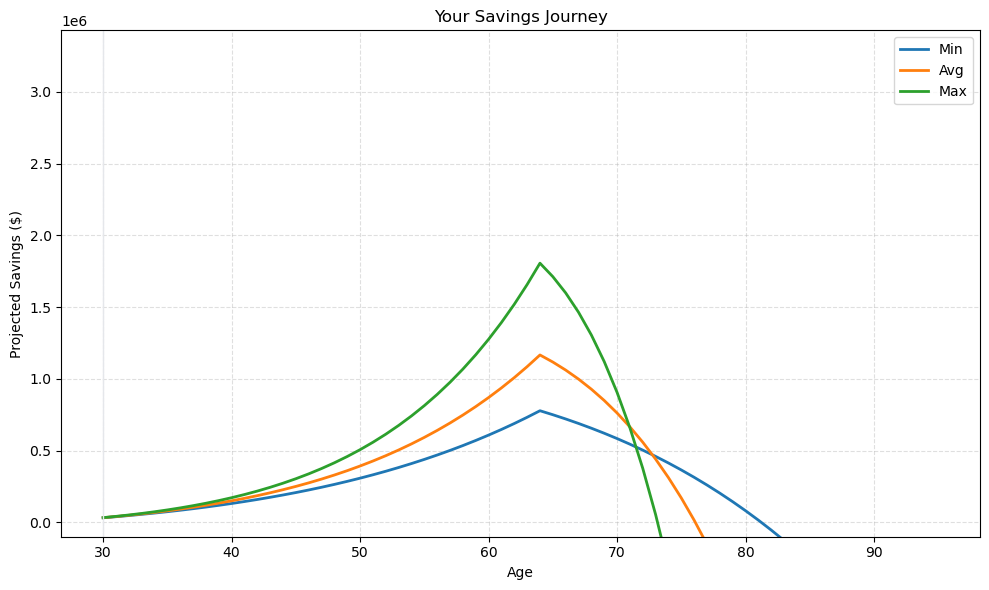

In [42]:
from matplotlib import pyplot as plt
def plot_savings(rows: List[YearRow]):
    ages = [r.age for r in rows]
    min_vals = [r.savings.min for r in rows]
    avg_vals = [r.savings.avg for r in rows]
    max_vals = [r.savings.max for r in rows]

    plt.figure(figsize=(10,6))
    plt.plot(ages, min_vals, label="Min", linewidth=2)
    plt.plot(ages, avg_vals, label="Avg", linewidth=2)
    plt.plot(ages, max_vals, label="Max", linewidth=2)
    plt.axvline(rows[0].age, color="#e5e7eb", linewidth=1)  # just visual; optional

    plt.ylim(bottom=-100000)
    plt.title("Your Savings Journey")
    plt.xlabel("Age")
    plt.ylabel("Projected Savings ($)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_savings(table)


In [46]:
if __name__ == "__main__":
    # Example:
    # - Age 30 now, retire at 65
    # - 25k current savings
    # - Want 40k/year in today's dollars in retirement
    # - Contributions: 6k/year flat, until 65
    basic = BasicInfo(
        currentAge=22,
        retirementAge=63,
        currentSavings=0,
        retirementSpendingRaw=40000,
        finalAge=95,
    )

    assumptions = GrowthAssumptions(
        annualInflation=0.03,
        inflationErrorMargin=0.02,        # min=1%, avg=3%, max=5%
        investmentReturnRate=0.06,
        investmentReturnErrorMargin=0.01  # min=4%, avg=6%, max=8%
    )

    contrib_plan = SavingsPlan(
        breakpoints=[
            ContributionBreakpoint(fromAge=22, base=1000, changeYoY=0.03)
        ]
    )

    spending_plan = SpendingPlan(changeYoY=0.0)

    table = project_savings_table(
        basic=basic,
        assumptions=assumptions,
        plan=contrib_plan,
        spending=spending_plan,
    )

    # Print a few rows to sanity-check
    for r in table[:50]:
        print(
            f"Age {r.age} | Year {r.year} | Contrib {r.contribution:.0f} | "
            f"SpendAvg {r.spending.avg:.0f} | SavAvg {r.savings.avg:.2f} | SavMin {r.savings.min:.2f} | SavMax {r.savings.max:.2f}"
        )


Age 22 | Year 2025 | Contrib 1000 | SpendAvg 0 | SavAvg 1000.00 | SavMin 1000.00 | SavMax 1000.00
Age 23 | Year 2026 | Contrib 1030 | SpendAvg 0 | SavAvg 2090.00 | SavMin 2080.00 | SavMax 2100.00
Age 24 | Year 2027 | Contrib 1061 | SpendAvg 0 | SavAvg 3276.30 | SavMin 3244.90 | SavMax 3307.90
Age 25 | Year 2028 | Contrib 1093 | SpendAvg 0 | SavAvg 4565.61 | SavMin 4499.87 | SavMax 4632.18
Age 26 | Year 2029 | Contrib 1126 | SpendAvg 0 | SavAvg 5965.05 | SavMin 5850.37 | SavMax 6081.94
Age 27 | Year 2030 | Contrib 1159 | SpendAvg 0 | SavAvg 7482.23 | SavMin 7302.17 | SavMax 7666.95
Age 28 | Year 2031 | Contrib 1194 | SpendAvg 0 | SavAvg 9125.21 | SavMin 8861.33 | SavMax 9397.69
Age 29 | Year 2032 | Contrib 1230 | SpendAvg 0 | SavAvg 10902.60 | SavMin 10534.27 | SavMax 11285.40
Age 30 | Year 2033 | Contrib 1267 | SpendAvg 0 | SavAvg 12823.53 | SavMin 12327.75 | SavMax 13342.15
Age 31 | Year 2034 | Contrib 1305 | SpendAvg 0 | SavAvg 14897.71 | SavMin 14248.91 | SavMax 15580.87
Age 32 | Ye

In [ ]:
from pydantic import BaseModel
from typing import List, Optional, Tuple
from datetime import datetime

class BasicInfo(BaseModel):
    currentAge: int
    retirementAge: int
    currentSavings: float
    retirementSpendingRaw: float

class ScenarioValues(BaseModel):
    min: float
    avg: float
    max: float

class GrowthScenarios(BaseModel):
    inflation: ScenarioValues
    growth: ScenarioValues

class GrowthAssumptions(BaseModel):
    annualInflation: float
    inflationErrorMargin: float
    investmentReturnRate: float
    investmentReturnErrorMargin: float

    def to_scenarios(self):
        return GrowthScenarios(
            inflation=ScenarioValues(
                min=self.annualInflation - self.inflationErrorMargin,
                avg=self.annualInflation,
                max=self.annualInflation + self.inflationErrorMargin,
            ),
            growth=ScenarioValues(
                min=self.investmentReturnRate - self.investmentReturnErrorMargin,
                avg=self.investmentReturnRate,
                max=self.investmentReturnRate + self.investmentReturnErrorMargin,
            ),
        )


#use case example
'''
assumptions = GrowthAssumptions(
    annualInflation=0.03,
    inflationErrorMargin=0.02,
    investmentReturnRate=0.06,
    investmentReturnErrorMargin=0.01
)
'''
#scenarios = assumptions.to_scenarios()
#print(scenarios.growth.min)


class ContributionBreakpoint(BaseModel):
    '''starting at fromAge, contribution = base * (1 + changeYoY)^(years since fromAge).
       If years is None, it runs until the next breakpoint (or retirement).'''
    fromAge: int
    base: float
    changeYoY: float
    years: Optional[int] = None

class SavingsPlan(BaseModel):
    breakpoints: List[ContributionBreakpoint] = []

class YearRow(BaseModel):
    age: int
    year: int
    contribution: float
    growth: ScenarioValues
    savings: ScenarioValues

class YearRowWithSpending(YearRow):
    #inherits age, year, contribution, growth, savings
    spending: ScenarioValues

#helper functions here
def _make_intervals(
    rows: List[ContributionBreakpoint],
    stop_age: int
) -> List[Tuple[int, int, ContributionBreakpoint]]:
    """Return [(startAge, endAgeExclusive, row), ...], sorted by start."""
    rows_sorted = sorted(rows, key=lambda r: r.fromAge)
    out: List[Tuple[int, int, ContributionBreakpoint]] = []
    for i, row in enumerate(rows_sorted):
        next_start = rows_sorted[i + 1].fromAge if i + 1 < len(rows_sorted) else stop_age
        # if years is None, run until the next breakpoint; else for `years` years
        end = row.fromAge + (row.years if row.years is not None else max(next_start - row.fromAge, 0))
        if end <= row.fromAge:      # guard against weird inputs
            end = next_start
        out.append((row.fromAge, end, row))
    return out

def _active_row(
    intervals: List[Tuple[int, int, ContributionBreakpoint]],
    age: int
) -> Optional[ContributionBreakpoint]:
    for start, end, row in intervals:
        if start <= age < end:
            return row
    return None

#main projection mechanism
def project_savings_table(
    basic: BasicInfo,
    assumptions: GrowthAssumptions,
    plan: SavingsPlan,
    current_year: Optional[int] = None,
) -> List[YearRow]:
    """
    Build a year-by-year table from currentAge..retirementAge (inclusive).

    Order of operations (per year):
      1) Add contribution at START of year (uses active breakpoint).
      2) Apply GROWTH for the year (min/avg/max nominal rates, annual compounding).
      3) Record row with nested {growth: {min,avg,max}, savings: {min,avg,max}}.

    Starts from basic.currentSavings BEFORE the first year's contribution.
    """
    scenarios = assumptions.to_scenarios()  # has scenarios.growth.min/avg/max

    # if no breakpoints are provided, default to "no contributions"
    default_years = max(0, basic.retirementAge - basic.currentAge)
    intervals = _make_intervals(
        plan.breakpoints or [ContributionBreakpoint(fromAge=basic.currentAge, base=0.0, changeYoY=0.0, years=default_years)],
        stop_age=basic.retirementAge + 1,
    )

    year0 = current_year or datetime.now().year

    bal_min = float(basic.currentSavings)
    bal_avg = float(basic.currentSavings)
    bal_max = float(basic.currentSavings)

    rows: List[YearRow] = []
    for step, age in enumerate(range(basic.currentAge, basic.retirementAge + 1)):
        year = year0 + step

        # compute contribution for this age
        contrib = 0.0
        rule = _active_row(intervals, age)
        if rule:
            t = age - rule.fromAge  # years since this breakpoint began
            contrib = rule.base * ((1.0 + rule.changeYoY) ** t)

        # 1) add contribution at start of year
        bal_min += contrib
        bal_avg += contrib
        bal_max += contrib

        # 2) apply growth for the full year
        gmin, gavg, gmax = scenarios.growth.min, scenarios.growth.avg, scenarios.growth.max
        bal_min *= (1.0 + gmin)
        bal_avg *= (1.0 + gavg)
        bal_max *= (1.0 + gmax)

        # 3) record row (rounded a bit for nice output)
        rows.append(YearRow(
            age=age,
            year=year,
            contribution=round(contrib, 2),
            growth=ScenarioValues(min=gmin, avg=gavg, max=gmax),
            savings=ScenarioValues(
                min=round(bal_min, 2),
                avg=round(bal_avg, 2),
                max=round(bal_max, 2),
            ),
        ))

    return rows

def project_savings_with_retirement(
    basic: BasicInfo,
    assumptions: GrowthAssumptions,
    plan: SavingsPlan,
    current_year: Optional[int] = None,
    years_after_retirement: int = 30,
    spending_change_yoy: float = 0.0,   # extra real change; 0 = same lifestyle in real terms
) -> List[YearRowWithSpending]:
    """
    Uses all your existing structures, but extends past retirement and applies drawdown.

    Conventions:
      - Working years (age < retirementAge):
            1) Contribution at START of year  (same as your current function)
            2) Then apply growth.
      - Retirement years (age >= retirementAge):
            1) Compute spending from retirementSpendingRaw (today's $), per band.
            2) Subtract spending at START of year (can go negative).
            3) Then apply growth.
      - Band pairing:
            Min  = worst case  = low growth + HIGH inflation (max drawdown)
            Avg  = middle      = avg growth + avg inflation
            Max  = best case   = high growth + LOW inflation (light drawdown)
    """

    s = assumptions.to_scenarios()

    # Pair growth + inflation for scenarios
    g_min, g_avg, g_max = s.growth.min, s.growth.avg, s.growth.max
    inf_min, inf_avg, inf_max = s.inflation.min, s.inflation.avg, s.inflation.max

    # How far to simulate (retirement + N years)
    end_age = basic.retirementAge + max(0, years_after_retirement)

    # Contribution schedule (only matters before retirement)
    default_years = max(0, basic.retirementAge - basic.currentAge)
    intervals = _make_intervals(
        plan.breakpoints or [
            ContributionBreakpoint(
                fromAge=basic.currentAge,
                base=0.0,
                changeYoY=0.0,
                years=default_years,
            )
        ],
        stop_age=basic.retirementAge,
    )

    year0 = current_year or datetime.now().year

    # Starting balances
    bal_min = float(basic.currentSavings)
    bal_avg = float(basic.currentSavings)
    bal_max = float(basic.currentSavings)

    # Base nominal spending at retirement for each band
    years_to_ret = max(0, basic.retirementAge - basic.currentAge)
    if basic.retirementSpendingRaw > 0:
        # Worst (min savings): use highest inflation
        spend0_min = basic.retirementSpendingRaw * (1 + inf_max) ** years_to_ret
        # Middle
        spend0_avg = basic.retirementSpendingRaw * (1 + inf_avg) ** years_to_ret
        # Best (max savings): use lowest inflation
        spend0_max = basic.retirementSpendingRaw * (1 + inf_min) ** years_to_ret
    else:
        spend0_min = spend0_avg = spend0_max = 0.0

    # Track last year's nominal spending per scenario
    prev_spend_min = None
    prev_spend_avg = None
    prev_spend_max = None

    rows: List[YearRowWithSpending] = []

    for step, age in enumerate(range(basic.currentAge, end_age + 1)):
        year = year0 + step
        contrib = 0.0
        spend_min = spend_avg = spend_max = 0.0

        # ---------- Working years ----------
        if age < basic.retirementAge:
            # 1) Contribution at START of year (same as your existing logic)
            rule = _active_row(intervals, age)
            if rule:
                t = age - rule.fromAge  # years since this breakpoint began
                contrib = rule.base * ((1 + rule.changeYoY) ** t)
                bal_min += contrib
                bal_avg += contrib
                bal_max += contrib

            # 2) Apply growth for the full year
            bal_min *= (1 + g_min)
            bal_avg *= (1 + g_avg)
            bal_max *= (1 + g_max)

        # ---------- Retirement years ----------
        else:
            # Helper: scenario-specific next year spending
            def next_spend(base0, prev, infl):
                if base0 <= 0:
                    return 0.0
                if prev is None:
                    # first retirement year
                    return base0
                # subsequent: last year's spending * (inflation + optional extra real change)
                return prev * (1 + infl + spending_change_yoy)

            # Worst path (savings.min): high inflation -> biggest spending
            spend_min = next_spend(spend0_min, prev_spend_min, inf_max)
            # Middle
            spend_avg = next_spend(spend0_avg, prev_spend_avg, inf_avg)
            # Best path (savings.max): low inflation -> smallest spending
            spend_max = next_spend(spend0_max, prev_spend_max, inf_min)

            prev_spend_min = spend_min
            prev_spend_avg = spend_avg
            prev_spend_max = spend_max

            # 1) Subtract spending at START of year
            bal_min -= spend_min
            bal_avg -= spend_avg
            bal_max -= spend_max

            # 2) Apply growth
            bal_min *= (1 + g_min)
            bal_avg *= (1 + g_avg)
            bal_max *= (1 + g_max)

        # Record this year
        rows.append(
            YearRowWithSpending(
                age=age,
                year=year,
                contribution=round(contrib, 2),
                growth=ScenarioValues(min=g_min, avg=g_avg, max=g_max),
                spending=ScenarioValues(
                    min=round(spend_min, 2),
                    avg=round(spend_avg, 2),
                    max=round(spend_max, 2),
                ),
                savings=ScenarioValues(
                    min=round(bal_min, 2),
                    avg=round(bal_avg, 2),
                    max=round(bal_max, 2),
                ),
            )
        )

    return rows

for r in table[:60]:
        print(
            f"Age {r.age} | Year {r.year} | Contrib {r.contribution:.0f} | "
            f"SpendAvg {r.spending.avg:.0f} | SavAvg {r.savings.avg:.2f} | SavMin {r.savings.min:.2f} | SavMax {r.savings.max:.2f}"
        )


Age 22 | Year 2025 | Contrib 1000 | SpendAvg 0 | SavAvg 1000.00 | SavMin 1000.00 | SavMax 1000.00
Age 23 | Year 2026 | Contrib 1030 | SpendAvg 0 | SavAvg 2090.00 | SavMin 2080.00 | SavMax 2100.00
Age 24 | Year 2027 | Contrib 1061 | SpendAvg 0 | SavAvg 3276.30 | SavMin 3244.90 | SavMax 3307.90
Age 25 | Year 2028 | Contrib 1093 | SpendAvg 0 | SavAvg 4565.61 | SavMin 4499.87 | SavMax 4632.18
Age 26 | Year 2029 | Contrib 1126 | SpendAvg 0 | SavAvg 5965.05 | SavMin 5850.37 | SavMax 6081.94
Age 27 | Year 2030 | Contrib 1159 | SpendAvg 0 | SavAvg 7482.23 | SavMin 7302.17 | SavMax 7666.95
Age 28 | Year 2031 | Contrib 1194 | SpendAvg 0 | SavAvg 9125.21 | SavMin 8861.33 | SavMax 9397.69
Age 29 | Year 2032 | Contrib 1230 | SpendAvg 0 | SavAvg 10902.60 | SavMin 10534.27 | SavMax 11285.40
Age 30 | Year 2033 | Contrib 1267 | SpendAvg 0 | SavAvg 12823.53 | SavMin 12327.75 | SavMax 13342.15
Age 31 | Year 2034 | Contrib 1305 | SpendAvg 0 | SavAvg 14897.71 | SavMin 14248.91 | SavMax 15580.87
Age 32 | Ye

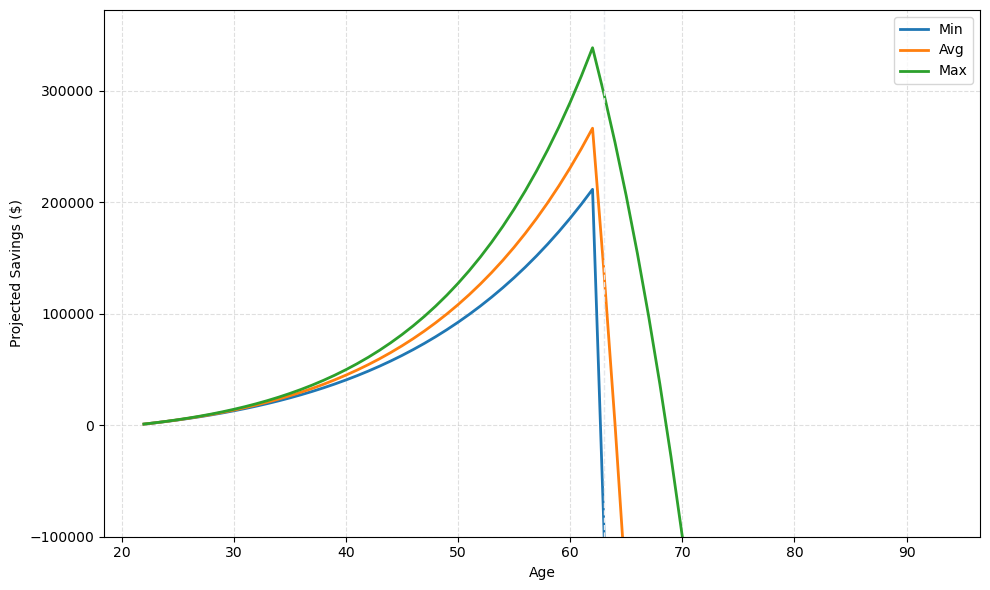

In [51]:
basic = BasicInfo(
    currentAge=22,
    retirementAge=63,
    currentSavings=0,
    retirementSpendingRaw=40000,  # today's dollars
)

assumptions = GrowthAssumptions(
    annualInflation=0.03,
    inflationErrorMargin=0.02,        # 1%–5%
    investmentReturnRate=0.06,
    investmentReturnErrorMargin=0.01  # 4%–8%
)

plan = SavingsPlan(
    breakpoints=[
        ContributionBreakpoint(fromAge=22, base=1000.0, changeYoY=0.03)
    ]
)

rows = project_savings_with_retirement(basic, assumptions, plan)

# quick visual check
import matplotlib.pyplot as plt

ages = [r.age for r in rows]
min_vals = [r.savings.min for r in rows]
avg_vals = [r.savings.avg for r in rows]
max_vals = [r.savings.max for r in rows]

plt.figure(figsize=(10,6))
plt.plot(ages, min_vals, label="Min", linewidth=2)
plt.plot(ages, avg_vals, label="Avg", linewidth=2)
plt.plot(ages, max_vals, label="Max", linewidth=2)
plt.axvline(basic.retirementAge, color="#e5e7eb", linestyle="--", linewidth=1)
plt.xlabel("Age")
plt.ylim(bottom=-100000, top=max(max_vals)*1.1)
plt.ylabel("Projected Savings ($)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
